# Progress Reporting and Command Observers <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F11_Progress.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

SimpleITK `Filter`s and other classes derived from `ProcessObject`s have the ability for user code to be executed when certain events occur. This is known as the Command and Observer design patters to implement user callbacks. This allows for the monitoring and abortion of processes as they are being executed.

Consider the following image source which takes a few seconds to execute. It would be nice to quickly know how long your going to need to wait, to know if you can go get a cup of coffee.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk

print(sitk.Version())

import sys
import os
import threading

from myshow import myshow
from myshow import myshow3d

SimpleITK Version: 2.2.0 (ITK 5.3)
Compiled: Aug 25 2022 19:08:15



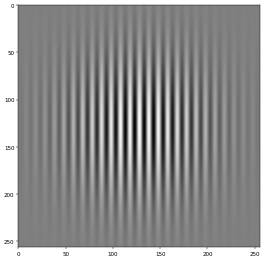

In [2]:
size = 256  # if this is too fast increase the size
img = sitk.GaborSource(
    sitk.sitkFloat32,
    size=[size] * 3,
    sigma=[size * 0.2] * 3,
    mean=[size * 0.5] * 3,
    frequency=0.1,
)
myshow3d(img, zslices=[int(size / 2)], dpi=40);

In [3]:
myshow(img);

interactive(children=(IntSlider(value=127, description='z', max=255), Output()), _dom_classes=('widget-interac…

We need to add a command to display the progress reported by the `ProcessObject::GetProgress` method during the `sitkProgressEvent`. This involves three components:

 1. Events
 2. ProcessObject's methods
 3. Commands
 
 We'll look at some examples after a brief explanation of these components.
 
### Events

The avaiable events to observed are defined in a namespace enumeration.

<table>
 <tr><td>sitkAnyEvent</td><td>Occurs for all event types.</td></tr>
 <tr><td>sitkAbortEvent</td><td>Occurs after the process has been aborted, but before exiting the Execute method.</td></tr>
 <tr><td>sitkDeleteEvent</td><td>Occurs when the underlying itk::ProcessObject is deleted.</td></tr>
 <tr><td>sitkEndEvent</td><td>Occurs at then end of normal processing.</td></tr>
 <tr><td>sitkIterationEvent</td><td>Occurs with some algorithms that run for a fixed or undetermined number of iterations.</td></tr>
 <tr><td>sitkProgressEvent</td><td>Occurs when the progress changes in most process objects.</td></tr>
 <tr><td>sitkStartEvent</td><td>Occurs when then itk::ProcessObject is starting.</td></tr>
 <tr><td>sitkUserEvent</td><td>Other events may fall into this enumeration.</td></tr>
</table>

The convention of pre-fixing enums with "sitk" is continued, although it's getting a little crowded. 

C++ is more strongly typed than Python it allows for implicit conversion from an enum type to an int, but not from an int to an enum type. Care needs to be made to ensure the correct enum value is passed in Python.

### ProcessObject's methods

To be able to interface with the `ProcessObject` during execution, the object-oriented interface must be used to access the method of the ProcessObject. While any constant member function can be called during a command call-back there are two common methods:

1. `ProcessObject::GetProgress()`
2. `ProcessObject::Abort()`

The methods are only valid during the `Command` while a process is being executed, or when the process is not in the `Execute` method.

Additionally it should be noted that follow methods can *not* be called during a command or from another thread during execution `Execute` and `RemoveAllCommands`. In general the `ProcessObject` should not be modified during execution.


### Commands

The command design pattern is used to allow user code to be executed when an event occurs. It is implemented in the `Command` class. The `Command` class provides an `Execute` method to be overridden in derived classes. 

There are three ways to define a command with SimpleITK in Python.

1. Derive from the `Command` class.
2. Use the `PyCommand` class' `SetCallbackPyCallable` method.
3. Use an inline `lambda` function in `ProcessOject::AddCommand`.

In [ ]:
help(sitk.Command)

In [ ]:
class MyCommand(sitk.Command):
    def __init__(self):
        # required
        super(MyCommand, self).__init__()

    def Execute(self):
        print("MyCommand::Execute Called")


cmd = MyCommand()
cmd.Execute()

In [ ]:
help(sitk.PyCommand)

In [ ]:
cmd = sitk.PyCommand()
cmd.SetCallbackPyCallable(lambda: print("PyCommand Called"))
cmd.Execute()

Back to watching the progress of out Gabor image source. First lets create the filter as an object

In [ ]:
size = 256
filter = sitk.GaborImageSource()
filter.SetOutputPixelType(sitk.sitkFloat32)
filter.SetSize([size] * 3)
filter.SetSigma([size * 0.2] * 3)
filter.SetMean([size * 0.5] * 3)
filter.SetFrequency(0.1)
img = filter.Execute()
myshow3d(img, zslices=[int(size / 2)], dpi=40);

### The ProcessObject interface for the Invoker or Subject

SimpleITK doesn't have a large heirachy of inheritance. It has been kept to a minimal, so there is no common `Object` or `LightObject` base class as ITK has. As most of the goals for the events have to do with observing processes, the "Subject" interface of the Observer patter or the "Invoker" part of the Command design pattern, has been added to a `ProcessObject` base class for filters.

The `ProcessObject` base class has the following methods of handling commands: `AddCommand`, `RemoveAllCommands`, and `HasCommand`.

Adding these functionalities are not available in the procedural interface available for SimpleITK. They are only available through the Object Oriented interface, and break the method chaining interface.

In [ ]:
help(sitk.ProcessObject)

### Deriving from the `Command` class
The traditional way of using Commands in ITK involves deriving from the `Command` class and adding to the `ProcessObject`.

In [ ]:
class MyCommand(sitk.Command):
    def __init__(self, msg):
        # required
        super(MyCommand, self).__init__()
        self.msg = msg

    def __del__(self):
        print(f'MyCommand begin deleted: "{self.msg}"')

    def Execute(self):
        print(self.msg)

In [ ]:
cmd1 = MyCommand("Start")
cmd2 = MyCommand("End")
filter.RemoveAllCommands()  # this line is here so we can easily re-execute this code block
filter.AddCommand(sitk.sitkStartEvent, cmd1)
filter.AddCommand(sitk.sitkEndEvent, cmd2)
filter.Execute()

A reference to the `Command` object must be maintained, or else it will be removed from the `ProcessObject`.

In [ ]:
filter.AddCommand(sitk.sitkStartEvent, MyCommand("stack scope"))
print("Before Execution")
filter.Execute()

### Using a `labmda` function as the `Command`
In Python the `AddCommand` has been extended to accept `PyCommand` objects and implicitly creates a `PyCommand` from a callable python argument. This is **really** useful.

In [ ]:
filter.RemoveAllCommands()  # this line is here so we can easily re-execute this code block
filter.AddCommand(sitk.sitkStartEvent, lambda: print("Starting...", end=""))
filter.AddCommand(sitk.sitkStartEvent, lambda: sys.stdout.flush())
filter.AddCommand(sitk.sitkEndEvent, lambda: print("Done"))
filter.Execute()

### Access to ITK data during command execution
The commands are not too useful unless you can query the filter through the SimpleITK interface. A couple status variables and methods are exposed in the SimpleITK `ProcessObject` through the polymorphic interface of the same ITK class. 

In [ ]:
filter.RemoveAllCommands()
filter.AddCommand(
    sitk.sitkProgressEvent,
    lambda: print(f"\rProgress: {100*filter.GetProgress():03.1f}%...", end=""),
)
filter.AddCommand(sitk.sitkProgressEvent, lambda: sys.stdout.flush())
filter.AddCommand(sitk.sitkEndEvent, lambda: print("Done"))
filter.Execute()

### Utilizing Jupyter Notebooks and Commands

Utilization of commands and events frequently occurs with advanced integration into graphical user interfaces. Let us now export this advanced integration into Jupyter Notebooks.

Jupyter notebooks support displaying output as HTML, and execution of javascript on demand. Together this can produce animation.

In [ ]:
import uuid
from IPython.display import HTML, Javascript, display

divid = str(uuid.uuid4())

html_progress = f"""
<p style="margin:5px">FilterName:</p>
<div style="border: 1px solid black;padding:1px;margin:5px">
  <div id="{divid}" style="background-color:blue; width:0%%">&nbsp;</div>
</div>
"""


def command_js_progress(processObject):
    p = processObject.GetProgress()
    display(Javascript("$('div#%s').width('%i%%')" % (divid, int(p * 100))))

In [ ]:
filter.RemoveAllCommands()
filter.AddCommand(sitk.sitkStartEvent, lambda: display(HTML(html_progress)))
filter.AddCommand(sitk.sitkProgressEvent, lambda: command_js_progress(filter))

filter.Execute()

### Support for Bi-direction JavaScript

It's possible to get button in HTML to execute python code...

In [ ]:
import uuid
from IPython.display import HTML, Javascript, display

g_Abort = False
divid = str(uuid.uuid4())

html_progress_abort = f"""
<div style="background-color:gainsboro; border:2px solid black;padding:15px">
<p style="margin:5px">FilterName:</p>
<div style="border: 1px solid black;padding:1px;margin:5px">
  <div id="{divid}" style="background-color:blue; width:0%%">&nbsp;</div>
</div>
<button onclick="set_value()" style="margin:5px" >Abort</button>
</div>
"""

javascript_abort = """
<script type="text/Javascript">
    function set_value(){
        var command = "g_Abort=True"
        console.log("Executing Command: " + command);
        
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
    }
</script>
"""


def command_js_progress_abort(processObject):
    p = processObject.GetProgress()
    display(Javascript("$('div#%s').width('%i%%')" % (divid, int(p * 100))))
    if g_Abort:
        processObject.Abort()


def command_js_start_abort():
    g_Abort = False

In [ ]:
g_Abort = False
filter.RemoveAllCommands()
filter.AddCommand(sitk.sitkStartEvent, command_js_start_abort)
filter.AddCommand(
    sitk.sitkStartEvent, lambda: display(HTML(html_progress_abort + javascript_abort))
)
filter.AddCommand(sitk.sitkProgressEvent, lambda: command_js_progress_abort(filter))

A caveat with this approach is that the IPython kernel must continue to execute while the filter is running. So we must place the filter in a thread.

In [ ]:
import threading

threading.Thread(target=lambda: filter.Execute()).start()

While the `lambda` command are convenient, the lack for having an object to hold data can still be problematic. For example in the above code the uuid, is used to uniquely identify the HTML element. So if the filter is executed multiple times then the JavaScript update will be confused on what to update.

In [ ]:
#### The following shows a failure that you will want to avoid.
threading.Thread(target=lambda: filter.Execute()).start()

### A Reusable class for IPython Progress

There currently are too many caveats without support for Abort. Let us create a reusable class which will automatically generate the UUID and just display the progress.

In [ ]:
import uuid
from IPython.display import HTML, Javascript, display


class HTMLProgressWatcher:
    def __init__(self, po):
        self.processObject = po
        self.abort = False

        po.AddCommand(sitk.sitkStartEvent, lambda: self.cmdStartEvent())
        po.AddCommand(sitk.sitkProgressEvent, lambda: self.cmdProgressEvent())
        po.AddCommand(sitk.sitkEndEvent, lambda: self.cmdEndEvent())

    def cmdStartEvent(self):
        global sitkIPythonProgress_UUID
        self.abort = False
        self.divid = str(uuid.uuid4())

        try:
            sitkIPythonProgress_UUID[self.divid] = self
        except NameError:
            sitkIPythonProgress_UUID = {self.divid: self}

        html_progress_abort = f"""
<p style="margin:5px">{self.processObject.GetName()}:</p>
<div style="border: 1px solid black;padding:1px;margin:5px">
  <div id="{self.divid}" style="background-color:blue; width:0%%">&nbsp;</div>
</div>
"""

        display(HTML(html_progress_abort + javascript_abort))

    def cmdProgressEvent(self):
        p = self.processObject.GetProgress()
        display(Javascript("$('div#%s').width('%i%%')" % (self.divid, int(p * 100))))
        if self.abort:
            self.processObject.Abort()

    def cmdEndEvent(self):
        global sitkIPythonProgress_UUID
        del sitkIPythonProgress_UUID[self.divid]
        del self.divid

In [ ]:
filter.RemoveAllCommands()
watcher = HTMLProgressWatcher(filter)

In [ ]:
filter.Execute()

In [ ]:
?threading.Thread.start